#LSTM

[*********************100%***********************]  1 of 1 completed
<ipython-input-4-7cd317c62216>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date']) # Convert 'Date' to datetime


Price      Adj Close     Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                                   
2010-01-04  6.447411  7.643214  7.660714  7.585000  7.622500  493729600
2010-01-05  6.458559  7.656429  7.699643  7.616071  7.664286  601904800
2010-01-06  6.355828  7.534643  7.686786  7.526786  7.656429  552160000
2010-01-07  6.344077  7.520714  7.571429  7.466071  7.562500  477131200
2010-01-08  6.386256  7.570714  7.571429  7.466429  7.510714  447610800


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - loss: 0.0014 - val_loss: 1.5051e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 288ms/step - loss: 7.5589e-05 - val_loss: 1.0241e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - loss: 6.4567e-05 - val_loss: 8.5339e-05
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - loss: 4.1280e-05 - val_loss: 8.8253e-05
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 4.1613e-05 - val_loss: 1.1400e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step - loss: 4.0663e-05 - val_loss: 9.1331e-05
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 297ms/step - loss: 5.3274e-05 - val_loss: 2.8920e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - loss: 7.0087e-05 - val_loss: 1.4646e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - loss: 4.0808e-05 - val_loss: 7.6213e-05
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 299ms/step - loss: 3.8332e-05 - val_loss: 8.3864e-05
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - l

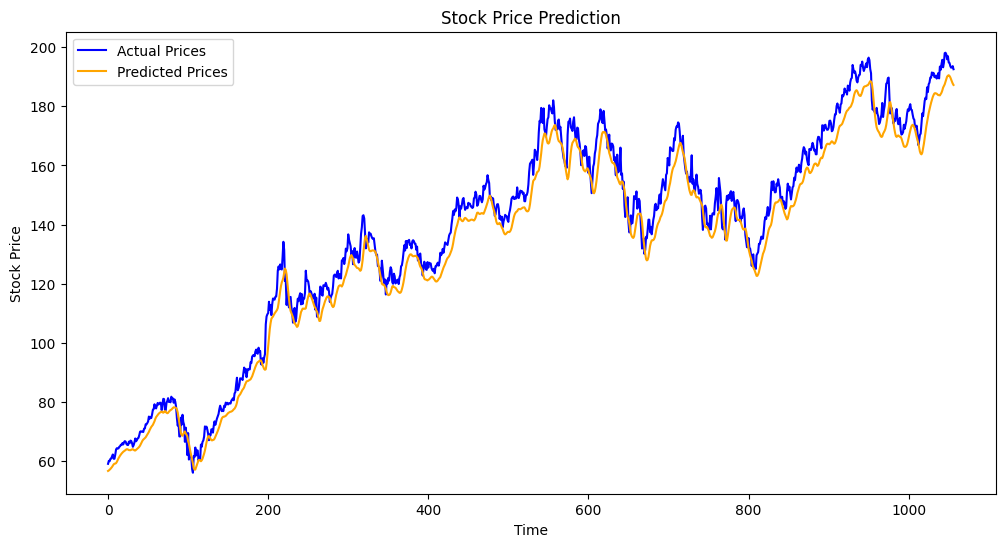

In [4]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding

# Load dataset
# Replace 'your_dataset.csv' with the path to your dataset
import yfinance as yf
data = yf.download("AAPL", start="2010-01-01", end="2023-12-31")
data.to_csv("apple_stock.csv")


# Preview data
print(data.head())

# Extract relevant columns (e.g., 'Date', 'Close')
data = data[['Close']] # Select only the 'Close' column
data.reset_index(inplace=True)  # Reset the index to make 'Date' a column
data['Date'] = pd.to_datetime(data['Date']) # Convert 'Date' to datetime
data.set_index('Date', inplace=True) # Set 'Date' as the index again

# Data preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values)

# Define hyperparameters
LOOKBACK = 60  # Number of past days used for prediction
BATCH_SIZE = 64
EPOCHS = 50

# Prepare training and testing datasets
def prepare_data(dataset, lookback):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i - lookback:i, 0])  # Previous 'lookback' days
        y.append(dataset[i, 0])              # Next day's value
    return np.array(X), np.array(y)

# Split dataset into training (70%) and testing (30%)
training_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size - LOOKBACK:]

X_train, y_train = prepare_data(train_data, LOOKBACK)
X_test, y_test = prepare_data(test_data, LOOKBACK)

# Reshape data for LSTM input (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()

# Embedding Layer (optional, for categorical or high-dimensional input)
# If not needed, remove the following line
# model.add(Embedding(input_dim=10000, output_dim=128, input_length=X_train.shape[1])) # This line is removed

# Add LSTM layers
model.add(LSTM(units=128, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1))) # input_shape is added here
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(LSTM(units=128, return_sequences=False, activation='tanh'))
model.add(Dropout(0.2))

# Dense layers for final output
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model on the test set
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)  # Convert back to original scale
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test_scaled, predicted_prices))
mape = mean_absolute_percentage_error(y_test_scaled, predicted_prices)
r2 = r2_score(y_test_scaled, predicted_prices)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R-squared: {r2}")

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='orange')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


#Traditional RNN

[*********************100%***********************]  1 of 1 completed
<ipython-input-3-99c0825f3c8c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


Price      Adj Close     Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                                   
2010-01-04  6.447412  7.643214  7.660714  7.585000  7.622500  493729600
2010-01-05  6.458558  7.656429  7.699643  7.616071  7.664286  601904800
2010-01-06  6.355826  7.534643  7.686786  7.526786  7.656429  552160000
2010-01-07  6.344078  7.520714  7.571429  7.466071  7.562500  477131200
2010-01-08  6.386254  7.570714  7.571429  7.466429  7.510714  447610800


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0878 - val_loss: 8.6911e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0043 - val_loss: 6.1951e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021 - val_loss: 3.3438e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013 - val_loss: 7.1944e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - val_loss: 2.5089e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.3958e-04 - val_loss: 2.5074e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.2308e-04 - val_loss: 4.6063e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.6911e-04 - val_loss: 2.0080e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.6692e-04 - val_loss: 3.1758e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.6176e-04 - val_loss: 2.2983e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7963e-04 - val_loss: 1.572

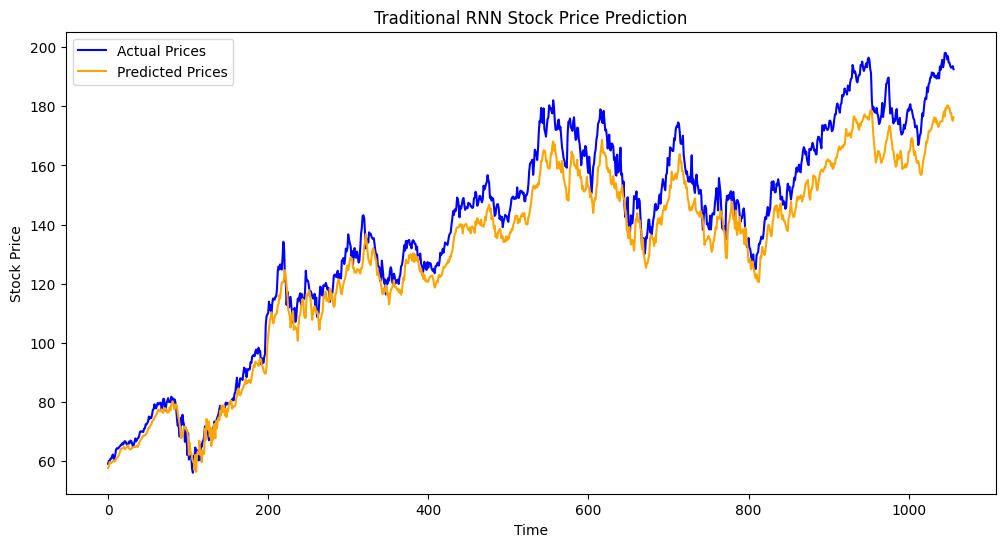

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Load dataset
# Replace 'your_dataset.csv' with the path to your dataset
import yfinance as yf
data = yf.download("AAPL", start="2010-01-01", end="2023-12-31")
data.to_csv("apple_stock.csv")

# Preview the dataset
print(data.head())

# Extract relevant columns (e.g., 'Date' and 'Close')
# The 'Date' column is already the index, so we just need to select 'Close'
data = data[['Close']]  # Select only the 'Close' column
# Reset the index to make 'Date' a regular column again
data.reset_index(inplace=True)
# Now you can access the 'Date' column
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Data preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values)

# Define hyperparameters
LOOKBACK = 60  # Number of past days used for prediction
BATCH_SIZE = 64
EPOCHS = 50

# Prepare training and testing datasets
def prepare_data(dataset, lookback):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i - lookback:i, 0])  # Previous 'lookback' days
        y.append(dataset[i, 0])              # Next day's value
    return np.array(X), np.array(y)

# Split dataset into training (70%) and testing (30%)
training_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size - LOOKBACK:]

X_train, y_train = prepare_data(train_data, LOOKBACK)
X_test, y_test = prepare_data(test_data, LOOKBACK)

# Reshape data for RNN input (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the RNN model
model = Sequential()

# Add RNN layers
model.add(SimpleRNN(units=128, activation='tanh', input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(SimpleRNN(units=128, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))

# Dense layers for output
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model on the test set
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)  # Convert back to original scale
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test_scaled, predicted_prices))
mape = mean_absolute_percentage_error(y_test_scaled, predicted_prices)
r2 = r2_score(y_test_scaled, predicted_prices)

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R-squared: {r2}")

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='orange')
plt.title('Traditional RNN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


#Random Forest


[*********************100%***********************]  1 of 1 completed
<ipython-input-9-3f2beb3ce38c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Price      Adj Close     Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                                   
2010-01-04  6.447412  7.643214  7.660714  7.585000  7.622500  493729600
2010-01-05  6.458558  7.656429  7.699643  7.616071  7.664286  601904800
2010-01-06  6.355826  7.534643  7.686786  7.526786  7.656429  552160000
2010-01-07  6.344078  7.520714  7.571429  7.466071  7.562500  477131200
2010-01-08  6.386254  7.570714  7.571429  7.466429  7.510714  447610800


<ipython-input-9-3f2beb3ce38c>:73: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_pred_train_df.fillna(0, inplace=True)  # Fill other columns with 0, or appropriate values if available
<ipython-input-9-3f2beb3ce38c>:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_pred_test_df.fillna(0, inplace=True)  # Fill other columns with 0, or appropriate values if available


Train RMSE: 0.2195122100872168
Test RMSE: 81.51102403188841
Test MAPE: 0.48969661483833465
Test R-squared: -4.373852467066437


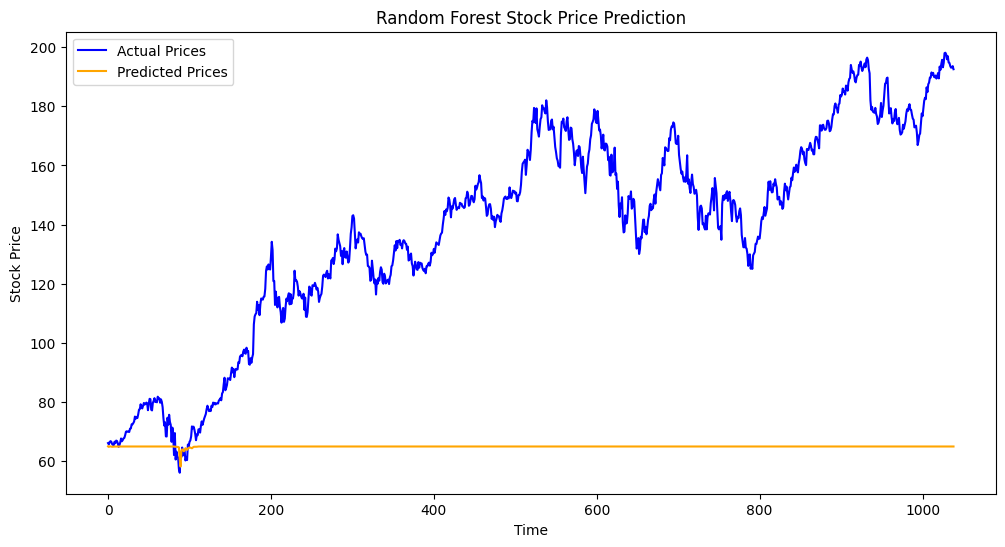

In [9]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load dataset
# Replace 'your_dataset.csv' with the path to your dataset
import yfinance as yf
data = yf.download("AAPL", start="2010-01-01", end="2023-12-31")
data.to_csv("apple_stock.csv")

# Preview the dataset
print(data.head())

# Extract relevant columns (e.g., 'Date' and 'Close')
# 'Date' is already the index, so we just need to reset it to a column
data.reset_index(inplace=True) # Reset the index to bring 'Date' back as a column
data = data[['Date', 'Close']] # Now you can select 'Date' and 'Close'
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


# Data preprocessing
# Adding lag features for temporal representation (to simulate sequence learning)
LOOKBACK = 60  # Number of previous days used for prediction

def create_lag_features(data, lookback):
    lagged_data = data.copy()
    for lag in range(1, lookback + 1):
        lagged_data[f'lag_{lag}'] = lagged_data['Close'].shift(lag)
    lagged_data.dropna(inplace=True)
    return lagged_data

# Create lagged features
lagged_data = create_lag_features(data, LOOKBACK)

# Normalize data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(lagged_data), columns=lagged_data.columns, index=lagged_data.index)

# Split data into features (X) and target (y)
X = scaled_data.drop(columns=['Close'])
y = scaled_data['Close']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Build the Random Forest model
random_forest = RandomForestRegressor(
    n_estimators=100,  # Number of trees in the forest
    max_depth=10,      # Maximum depth of the tree
    random_state=42
)

# Train the model
random_forest.fit(X_train, y_train)

# Make predictions
y_pred_train = random_forest.predict(X_train)
y_pred_test = random_forest.predict(X_test)

# Reverse scaling for evaluation
y_train_actual = scaler.inverse_transform(scaled_data.loc[y_train.index])[:, 0]  # Use the scaled_data DataFrame for inverse transform, selecting the rows corresponding to y_train
y_test_actual = scaler.inverse_transform(scaled_data.loc[y_test.index])[:, 0]  # Use the scaled_data DataFrame for inverse transform, selecting the rows corresponding to y_test

# Create DataFrames with all the lag features for inverse_transform
y_pred_train_df = pd.DataFrame(index=y_train.index, columns=scaled_data.columns)
y_pred_train_df['Close'] = y_pred_train
y_pred_train_df.fillna(0, inplace=True)  # Fill other columns with 0, or appropriate values if available

y_pred_test_df = pd.DataFrame(index=y_test.index, columns=scaled_data.columns)
y_pred_test_df['Close'] = y_pred_test
y_pred_test_df.fillna(0, inplace=True)  # Fill other columns with 0, or appropriate values if available

y_pred_train_actual = scaler.inverse_transform(y_pred_train_df)[:, 0]  # Now inverse_transform works with the correct shape
y_pred_test_actual = scaler.inverse_transform(y_pred_test_df)[:, 0]  # Now inverse_transform works with the correct shape

# Evaluate performance
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_pred_train_actual))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_test_actual))
test_mape = mean_absolute_percentage_error(y_test_actual, y_pred_test_actual)
test_r2 = r2_score(y_test_actual, y_pred_test_actual)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAPE: {test_mape}")
print(f"Test R-squared: {test_r2}")

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(y_pred_test_actual, label='Predicted Prices', color='orange')
plt.title('Random Forest Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
